# 1. Instalacion Librerias Requeridas 

A continuación se debe realizar la instalación de las librerias request y pandas-profiling para la correcta ejecución del código. 
Este proceso solo es necesario una vez.

In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip3 install 'pandas-profiling[notebook]'

# 2. Importación Librerias Requeridas

Ahora vamos a importar las librerias necesarias para la ejecución 

In [6]:
import requests
import os
import pandas as pd
import json
import numpy as np
import re
from pandas import json_normalize
import sqlite3
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# 3. Descarga del Json

Al ingresar al API observamos que la lista de registros se puede descargar por día y no por mes, para solo hacer una descarga y guardarla en un solo dataframe creé una función donde el parametro de entrada es el día en formato str, la cual traerá como resultado el DataFrame del día indicado 

In [3]:
def descarga_json(dia):
    a='http://api.tvmaze.com/schedule/web?date=2020-12-'
    json_ob=requests.get(a+dia)
    json_en_text=json_ob.text
    json_cargado =json.loads(json_en_text)
    df_json=json_normalize(json_cargado)
    return df_json

Para crear el Dataframe del mes se crea una nueva variable donde se almacenaran todos los datos llamada **df_diciembre**

In [4]:
df_diciembre=[]

Ahora con un iterador **for** se ejecutará la función **descarga_json()** para que me almacene la información de todos los días en **df_diciembre**

In [7]:
x=0
for mes in ('01','02','03','04','05',
           '06','07','08','09','10',
           '11','12','13','14','15',
           '16','17','18','19','20',
           '21','22','23','24','25',
           '26','27','28','29','30',
           '31'):
    if x>0:
        df_diciembre = pd.concat([df_diciembre,descarga_json(mes)])
    else:
        x=x+1
        df_diciembre=descarga_json(mes)

In [8]:
#Vamos a ejecutar la siguiente función para que al imprimir el DataFrame
#Muestre todas las columnas
pd.set_option('max_columns', None)

Vamos a guardar el archivo Json con el nombre **Diciembre__2020.json**

In [9]:
df_diciembre.reset_index(inplace=True,drop=True)
js=df_diciembre.to_json('Diciembre__2020.json', orient ='columns')

# 4. Procesamiento del Dataframe

Al analizar el dataframe resultante de las descargas de los archivos json se evidencian varias columnas embebidas entre ellas es una señal de que hay diccionarios dentro de otros lo que es caracteristico de los arhivos json, poco a poco en la ejecución irmos limpiando los nombres de las columnas, en este paso solo le quitaremos la palabra **_embedded.** para no generar duplicados con información que se almacenará en otros dataframe

Tambien podemos evidenciar como estan ordenados los datos los cuales quedarán en diversos Dataframe para luego generar el modelo de datos, la data esta agrupada de la siguiente forma:

* Chapters:
    * Show:
        
            *Web_channel
        
            *dvd
        
            *externals
        
            *image
        
            *network
        


In [12]:
#Vamos a identificar las columnas
df_diciembre.columns

Index(['id', 'url', 'name', 'season', 'number', 'type', 'airdate', 'airtime',
       'airstamp', 'runtime', 'image', 'summary', 'rating.average',
       '_links.self.href', '_embedded.show.id', '_embedded.show.url',
       '_embedded.show.name', '_embedded.show.type', '_embedded.show.language',
       '_embedded.show.genres', '_embedded.show.status',
       '_embedded.show.runtime', '_embedded.show.averageRuntime',
       '_embedded.show.premiered', '_embedded.show.ended',
       '_embedded.show.officialSite', '_embedded.show.schedule.time',
       '_embedded.show.schedule.days', '_embedded.show.rating.average',
       '_embedded.show.weight', '_embedded.show.network',
       '_embedded.show.webChannel.id', '_embedded.show.webChannel.name',
       '_embedded.show.webChannel.country.name',
       '_embedded.show.webChannel.country.code',
       '_embedded.show.webChannel.country.timezone',
       '_embedded.show.webChannel.officialSite', '_embedded.show.dvdCountry',
       '_embedded.sh

In [13]:
#Ahora les vamos a cambiar el nombre 
df_diciembre.columns = ['id', 'url', 'name', 'season', 'number', 'type', 'airdate', 'airtime',
       'airstamp', 'runtime', 'image', 'summary', 'rating_average',
       '_links_self_href', 'show_id', 'show_url',
       'show_name', 'show_type', 'show_language',
       'show_genres', 'show_status',
       'show_runtime', 'show_averageRuntime',
       'show_premiered', 'show_ended',
       'show_officialSite', 'show_schedule_time',
       'show_schedule_days', 'show_rating_average',
       'show_weight', 'show_network',
       'show_webChannel_id', 'show_webChannel_name',
       'show_webChannel_country_name',
       'show_webChannel_country_code',
       'show_webChannel_country_timezone',
       'show_webChannel_officialSite', 'show_dvdCountry',
       'show_externals_tvrage', 'show_externals_thetvdb',
       'show_externals_imdb', 'show_image_medium',
       'show_image_original', 'show_summary',
       'show_updated', 'show__links_self_href',
       'show__links_previousepisode_href', 'image_medium',
       'image_original', 'show_network_id',
       'show_network_name', 'show_network_country_name',
       'show_network_country_code',
       'show_network_country_timezone',
       'show_network_officialSite',
       'show__links_nextepisode_href', 'show_webChannel',
       'show_image', 'show_webChannel_country',
       'show_dvdCountry_name', 'show_dvdCountry_code',
       'show_dvdCountry_timezone']
df_diciembre.head(2)

,id,url,name,season,number,type,airdate,airtime,airstamp,runtime,image,summary,rating_average,_links_self_href,show_id,show_url,show_name,show_type,show_language,show_genres,show_status,show_runtime,show_averageRuntime,show_premiered,show_ended,show_officialSite,show_schedule_time,show_schedule_days,show_rating_average,show_weight,show_network,show_webChannel_id,show_webChannel_name,show_webChannel_country_name,show_webChannel_country_code,show_webChannel_country_timezone,show_webChannel_officialSite,show_dvdCountry,show_externals_tvrage,show_externals_thetvdb,show_externals_imdb,show_image_medium,show_image_original,show_summary,show_updated,show__links_self_href,show__links_previousepisode_href,image_medium,image_original,show_network_id,show_network_name,show_network_country_name,show_network_country_code,show_network_country_timezone,show_network_officialSite,show__links_nextepisode_href,show_webChannel,show_image,show_webChannel_country,show_dvdCountry_name,show_dvdCountry_code,show_dvdCountry_timezone
0,1979824,https://www.tvmaze.com/episodes/1979824/sim-fo...,Chanyeol's Episode 16,4,16.0,regular,2020-12-01,06:00,2020-11-30T21:00:00+00:00,16.0,NaN,<p><b>#ObtainedAConversationalSkill #WeSetUpAT...,NaN,https://api.tvmaze.com/episodes/1979824,41648,https://www.tvmaze.com/shows/41648/sim-for-you,Sim for You,Reality,Korean,[],Running,16.0,16.0,2019-03-25,None,https://www.vlive.tv/video/121637,,"[Monday, Wednesday, Friday]",NaN,63,NaN,122.0,V LIVE,"Korea, Republic of",KR,Asia/Seoul,https://www.vlive.tv/home,NaN,NaN,361541.0,None,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...,<p><b>Sim for You</b> is a reality series that...,1608499007,https://api.tvmaze.com/shows/41648,https://api.tvmaze.com/episodes/1988862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979222,https://www.tvmaze.com/episodes/1979222/kotiki...,Серия 2,1,2.0,regular,2020-12-01,,2020-12-01T00:00:00+00:00,12.0,NaN,None,NaN,https://api.tvmaze.com/episodes/1979222,52198,https://www.tvmaze.com/shows/52198/kotiki,Котики,Scripted,Russian,[Comedy],Ended,12.0,12.0,2020-11-30,2020-12-11,http://epic-media.ru/project/kotiki,10:00,"[Monday, Tuesday, Wednesday, Thursday, Friday]",NaN,12,NaN,510.0,Epic Media,Russian Federation,RU,Asia/Kamchatka,None,NaN,NaN,392682.0,None,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...,None,1637555191,https://api.tvmaze.com/shows/52198,https://api.tvmaze.com/episodes/1986873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.1 Dataframe Chapters

Revisando el primer dataframe generado nos muestra que por cada registro hay un capitulo de un show presentado en el mes de diciembre, para la creación de este dataframe copiaremos las columnas que no anteceden la palabra show, exceptuando la columna **show_id** que nos permitirá conectar esta tabla a la tabla show que crearemos posteriormente, solo dejamos estas columnas ya que las que tienen esta palabra hacen referencia a la tabla en donde están embebidas

In [15]:
df_chapters = df_diciembre[['id',
 'url',
 'name',
 'season',
 'number',
 'type',
 'airdate',
 'airtime',
 'airstamp',
 'runtime',
 'image',
 'summary',
 'rating_average',
 '_links_self_href',
 'image_medium',
 'image_original',
 'show_id']].copy()


In [16]:
df_chapters.drop_duplicates(inplace=True) #Eliminamos los registros duplicados 
df_chapters.head(5) #Impromimos las primeras 5 filas

,id,url,name,season,number,type,airdate,airtime,airstamp,runtime,image,summary,rating_average,_links_self_href,image_medium,image_original,show_id
0,1979824,https://www.tvmaze.com/episodes/1979824/sim-fo...,Chanyeol's Episode 16,4,16.0,regular,2020-12-01,06:00,2020-11-30T21:00:00+00:00,16.0,NaN,<p><b>#ObtainedAConversationalSkill #WeSetUpAT...,NaN,https://api.tvmaze.com/episodes/1979824,NaN,NaN,41648
1,1979222,https://www.tvmaze.com/episodes/1979222/kotiki...,Серия 2,1,2.0,regular,2020-12-01,,2020-12-01T00:00:00+00:00,12.0,NaN,None,NaN,https://api.tvmaze.com/episodes/1979222,NaN,NaN,52198
2,2008027,https://www.tvmaze.com/episodes/2008027/lab-s-...,Лолита,2,6.0,regular,2020-12-01,,2020-12-01T00:00:00+00:00,29.0,NaN,None,NaN,https://api.tvmaze.com/episodes/2008027,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...,52933
3,1964565,https://www.tvmaze.com/episodes/1964565/core-s...,Episode 9,1,9.0,regular,2020-12-01,10:00,2020-12-01T02:00:00+00:00,24.0,NaN,None,NaN,https://api.tvmaze.com/episodes/1964565,NaN,NaN,51336
4,2052503,https://www.tvmaze.com/episodes/2052503/wu-she...,Episode 80,1,80.0,regular,2020-12-01,10:00,2020-12-01T02:00:00+00:00,8.0,NaN,None,NaN,https://api.tvmaze.com/episodes/2052503,NaN,NaN,54033


## 4.2 Dataframe Show

Para crear este dataframe tomaremos las columnas que no tengan otra agrupación (Ej:show_network_country). A estás columnas adicionaremos los id de show_webChannel_id y show_network_id para hacer conexiones entre los modelos de datos. Luego cambiaremos el nombre de las columnas para quitar el nombre de la agrupación

In [17]:
#Seleccionamos las columnas de dataframe 
df_show = df_diciembre[['show_id',
                         'show_url',
                         'show_name',
                         'show_type',
                         'show_language',
                         'show_genres',
                         'show_status',
                         'show_runtime',
                         'show_averageRuntime',
                         'show_premiered',
                         'show_ended',
                         'show_officialSite',
                         'show_schedule_time',
                         'show_schedule_days',
                         'show_rating_average',
                         'show_weight',
                         'show_network',
                         'show_summary',
                         'show_updated',
                         'show_image',
                         'show__links_self_href',
                         'show__links_previousepisode_href',
                         'show__links_nextepisode_href',
                         'show_webChannel_id',
                         'show_network_id'

                        ]
                        ].copy()
#Cambiamos el nombre a las columnas  
df_show.columns = [  'show_id',
                     'url',
                     'name',
                     'type',
                     'language',
                     'genres',
                     'status',
                     'runtime',
                     'averageRuntime',
                     'premiered',
                     'ended',
                     'officialSite',
                     'schedule_time',
                     'schedule_days',
                     'rating_average',
                     'weight',
                     'network',
                     'summary',
                     'updated',
                     'image',
                     'links_self_href',
                     'links_previousepisode_href',
                     'links_nextepisode_href',
                     'webChannel_id',
                     'network_id'
                  ]

In [18]:
#Eliminamos los registros duplicados 
df_show.drop_duplicates(subset=['show_id'],inplace=True)

Para este dataframe vamos a cambiar el tipo de datos a las columnas **genres** y **schedule_days** a string ya que se encuentran en formato list y pueden dar inconvenientes cuando se suban al modelo de datos en SQLite

In [19]:
df_show['genres'] = df_show['genres'].astype(str)
df_show['schedule_days'] =df_show['schedule_days'].astype(str)

In [20]:
df_show.reset_index(inplace=True,drop=True) #Reseteamos el index ya que se eliminaron filas 
df_show.head(2)

,show_id,url,name,type,language,genres,status,runtime,averageRuntime,premiered,ended,officialSite,schedule_time,schedule_days,rating_average,weight,network,summary,updated,image,links_self_href,links_previousepisode_href,links_nextepisode_href,webChannel_id,network_id
0,41648,https://www.tvmaze.com/shows/41648/sim-for-you,Sim for You,Reality,Korean,[],Running,16.0,16.0,2019-03-25,None,https://www.vlive.tv/video/121637,,"['Monday', 'Wednesday', 'Friday']",NaN,63,NaN,<p><b>Sim for You</b> is a reality series that...,1608499007,NaN,https://api.tvmaze.com/shows/41648,https://api.tvmaze.com/episodes/1988862,NaN,122.0,NaN
1,52198,https://www.tvmaze.com/shows/52198/kotiki,Котики,Scripted,Russian,['Comedy'],Ended,12.0,12.0,2020-11-30,2020-12-11,http://epic-media.ru/project/kotiki,10:00,"['Monday', 'Tuesday', 'Wednesday', 'Thursday',...",NaN,12,NaN,None,1637555191,NaN,https://api.tvmaze.com/shows/52198,https://api.tvmaze.com/episodes/1986873,NaN,510.0,NaN


## 4.3 Dataframe web_channel

En este dataframe aparece la información de si un programa se transmitió en un canal web (ej: Youtube, netflix) y la información del respectivo canal 

Siguiendo los parametros que hemos establecido ahora se creará el dataframe para web_channel

In [21]:
df_web_channel=df_diciembre[['show_webChannel_id',
                             'show_webChannel',
                             'show_webChannel_name',
                             'show_webChannel_country_name',
                             'show_webChannel_country_code',
                             'show_webChannel_country_timezone',
                             'show_webChannel_country',
                             'show_webChannel_officialSite']].copy()

In [22]:
df_web_channel.columns = ['webChannel_id',
                           'WebChannel',
                           'Name',
                           'Country_name',
                           'Country_code',
                           'Country_timezone',
                           'Country',
                           'officialSite']

In [24]:
df_web_channel.drop_duplicates(inplace=True)#Se eliminan duplicados 
df_web_channel.dropna(how='all',inplace=True)#Se eliminan filas vacias 
df_web_channel.reset_index(inplace=True,drop=True)#Se resetea el index
df_web_channel.head(2)

,webChannel_id,WebChannel,Name,Country_name,Country_code,Country_timezone,Country,officialSite
0,122.0,NaN,V LIVE,"Korea, Republic of",KR,Asia/Seoul,NaN,https://www.vlive.tv/home
1,510.0,NaN,Epic Media,Russian Federation,RU,Asia/Kamchatka,NaN,None


## 4.4 Dataframe externals

En este dataframe aparecen los datos de en que otras plataformas hay información del show a demás de la pagina de Tv Maze

Siguiendo los parametros que hemos establecido ahora se creará el dataframe para externals

In [26]:
df_externals=df_diciembre[['show_id',
                           'show_externals_tvrage',
                           'show_externals_thetvdb',
                           'show_externals_imdb']].copy()
df_externals.columns = ['show_id',
                        'tvrage',
                        'thetvdb',
                        'imdb']

In [27]:
df_externals.head(2)

,show_id,tvrage,thetvdb,imdb
0,41648,NaN,361541.0,None
1,52198,NaN,392682.0,None


En este caso ya que no hay id único para esta lista y por tal motivo se usó el Show id, esto genera inconvenientes ya que no todos los shoy tienen información externa, por tal motivo se eliminaran todas las filas en donde no hallan datos de algúno de los 3 sitios externos.

In [30]:
#Se crea una columna condicional para identificar las filas a eliminar 
df_externals['borrar_col']= np.where((df_externals['tvrage'].isnull()&
                                     df_externals['thetvdb'].isnull()&
                                     df_externals['imdb'].isnull()),'delete','ok')
#Se eliminan las filas identificadas
df_externals.drop(df_externals.loc[df_externals['borrar_col']=='delete'].index, inplace=True)
#Se elimina la columna creada
df_externals.drop(['borrar_col'],axis=1,inplace=True)
#Se eliminan valores duplicados 
df_externals.drop_duplicates(inplace=True)
#Se resetea el index
df_externals.reset_index(inplace=True,drop=True)
df_externals.head(2)

,show_id,tvrage,thetvdb,imdb
0,41648,NaN,361541.0,None
1,52198,NaN,392682.0,None


## 4.5 Dataframe image 

En este dataframe aparecen los links a las imagenes de los shows

Siguiendo los parametros que hemos establecido ahora se creará el dataframe para image

In [32]:
df_image=df_diciembre[[ 'show_id', 
                        'show_image_medium',
                        'show_image_original']].copy()

In [33]:
df_image.columns=['show_id', 
'medium',
'original']

In [34]:
df_image.drop_duplicates(inplace=True)
df_image.dropna(how='all',inplace=True)
df_image.reset_index(inplace=True,drop=True)
df_image.head(2)

,show_id,medium,original
0,41648,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...
1,52198,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...


## 4.6 Dataframe Network 

En este dataframe aparece la información de la cadena de televisión donde se transmite el show

Siguiendo los parametros que hemos establecido ahora se creará el dataframe para Network

In [35]:
df_network = df_diciembre[['show_network_id',
                           'show_network_name',
                           'show_network_officialSite',
                           'show_network_country_name',
                           'show_network_country_code',
                           'show_network_country_timezone']].copy()
df_network.columns=['network_id',
                    'name',
                    'OfficialSite',
                    'Country_name',
                    'Country_code',
                    'Country_timezone']

In [36]:
df_network.drop_duplicates(inplace=True)
df_network.dropna(how='all',inplace=True)
df_network.reset_index(inplace=True,drop=True)
df_network.head(2)

,network_id,name,OfficialSite,Country_name,Country_code,Country_timezone
0,308.0,ТНТ,NaN,Russian Federation,RU,Asia/Kamchatka
1,1282.0,CCTV-1,NaN,China,CN,Asia/Shanghai


## 4.7 Dataframe dvd 

En este dataframe aparece la información de los show que salen en DVD's

Siguiendo los parametros que hemos establecido ahora se creará el dataframe para dvd

In [38]:
df_dvd = df_diciembre[['show_id',
                       'show_dvdCountry',
                       'show_dvdCountry_name',
                       'show_dvdCountry_code',
                       'show_dvdCountry_timezone']].copy()

df_dvd.columns=['show_id',
                'Country',
                'Country_name',
                'Country_code',
                'Country_timezone']

In [39]:
df_dvd.drop_duplicates(inplace=True)
df_dvd.dropna(how='all',inplace=True)
df_dvd=df_dvd[df_dvd['Country_code'].notna()]
df_dvd.reset_index(inplace=True,drop=True)
df_dvd.head(2)

,show_id,Country,Country_name,Country_code,Country_timezone
0,61530,NaN,Japan,JP,Asia/Tokyo
1,44675,NaN,Ukraine,UA,Europe/Zaporozhye


## 4.8 Dataframe Countries 

Si bien no hay una columna específica para el país del show tenemos información de en que país se transmite en los dataframes web_channel, network y dvd. A partir de la información de estos vamos a contruir este dataframe que nos servirá en el modelado de los datos. 

Siguiendo los parametros que hemos establecido ahora se creará el dataframe para dvd

In [40]:
#Concatenamos una copia de los dataframes que vamos a usar 
df_countries=pd.concat([df_web_channel[['Country_name','Country_code','Country_timezone']].copy(),
                        df_network[['Country_name','Country_code','Country_timezone']].copy(),
                        df_dvd[['Country_name','Country_code','Country_timezone']].copy()])

df_countries.head(3)

,Country_name,Country_code,Country_timezone
0,"Korea, Republic of",KR,Asia/Seoul
1,Russian Federation,RU,Asia/Kamchatka
2,Russian Federation,RU,Asia/Kamchatka


In [42]:
df_countries.drop_duplicates(inplace=True)
df_countries.dropna(how='all',inplace=True)
df_countries.reset_index(inplace=True,drop=True)
df_countries.head(2)

,Country_name,Country_code,Country_timezone
0,"Korea, Republic of",KR,Asia/Seoul
1,Russian Federation,RU,Asia/Kamchatka


Ya tenemos todos nuestros dataframes listos, ahora los vamos a Enviar a la base de datos sqlite 

# 5. Almacenamiento de los datos en la base de datos (SQLite)

In [44]:
#Nos conectamos a la base de datos
conn = sqlite3.connect('series.db')

In [45]:
#Enviamos los dataframes para que se conviertan en tablas 
df_chapters.to_sql('chapters',conn,if_exists='replace',index=False)
df_dvd.to_sql('dvd',conn,if_exists='replace',index=False)
df_externals.to_sql('externals',conn,if_exists='replace',index=False)
df_image.to_sql('image',conn,if_exists='replace',index=False)
df_network.to_sql('network',conn,if_exists='replace',index=False)
df_web_channel.to_sql('web_channel',conn,if_exists='replace',index=False)
df_countries.to_sql('countries',conn,if_exists='replace',index=False)
df_show.to_sql('show',conn,if_exists='replace',index=False)

In [46]:
#cerramos la conexión a la base de datos 
conn.close()

# 6. Profiling de los dataframes

Se realizará el profiling para los dataframe creados y así posteriormente realizar su análisis

In [47]:
reporte_chapters = df_chapters.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_dvd = df_dvd.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_externals = df_externals.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_image = df_image.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_network = df_network.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_web_channel = df_web_channel.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_countries = df_countries.profile_report(sort='ascending', html={'style':{'full_width':True}})
reporte_show = df_show.profile_report(sort='ascending', html={'style':{'full_width':True}})


In [37]:
reporte_chapters.to_file(output_file='Profiling_chapters.html')
reporte_dvd.to_file(output_file='Profiling_dvd.html')
reporte_externals.to_file(output_file='Profiling_externals.html')
reporte_image.to_file(output_file='Profiling_image.html')
reporte_network.to_file(output_file='Profiling_network.html')
reporte_web_channel.to_file(output_file='Profiling_web_channel.html')
reporte_countries.to_file(output_file='Profiling_countries.html')
reporte_show.to_file(output_file='Profiling_show.html')

# 7. Dataframe preguntas de negocio

## 7.1 AverageRuntime por mes

El averageRuntime por type y mes puede salir de DataFrame df_show que tiene las columnas type y averageRuntime.

En este caso como solo tomamos el mes de diciembre vamos las columnas tomaran el valor del campo Type


Text(0.5, 1.0, 'averageRuntime por Type')

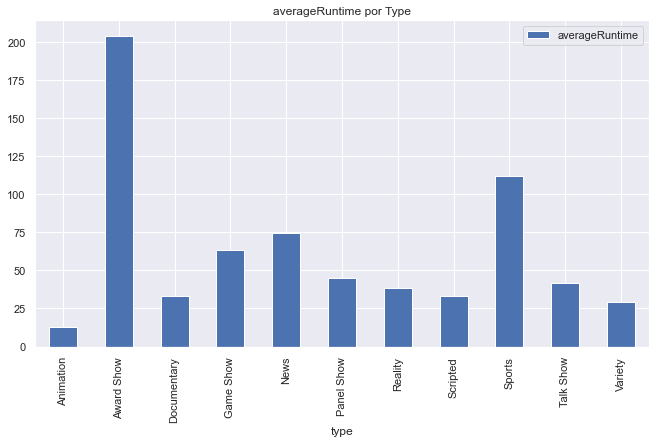

In [48]:
sns.set(rc={'figure.figsize':(11,6)})
df_show.groupby('type')['averageRuntime'].mean().plot(kind='bar',legend='Reverse')

plt.title('averageRuntime por Type')

## 7.2 Cantidad de series emitidas por genero por mes 

Igual que en el archivo anterior al solo analizar el mes de diciembre del 2020 en el gráfico solo apareceran los generos y la cantidad de series por genero.

Para esto el gráfico me mostrará la cantidad de series por genero, al validar el dataframe hay varias series que tienen dos o más generos, en estos casos esta serie contará para cada uno de los generos y las series que no tienen genero no serán contabilizadas

In [67]:
df_series=df_show[['genres']].copy()

In [68]:
df_series['genres_reform'] = df_series['genres'].apply(lambda x:re.findall("\'(.+?)\'", x))

In [69]:
df_series.head(2)

,genres,genres_reform
0,[],[]
1,['Comedy'],[Comedy]


In [70]:
#Definimos una función para traer cada uno de los géneros
def Extraer_info(list, col):
    for i in range(len(col)):
        for name in list[i]:
            if name not in col.columns:
                col[name] = 0
            col[name][i] = 1
    return col

In [79]:
#Extraemos la información en nuevas variables
Extraer_info(df_series['genres_reform'], df_series)


/var/folders/cz/8bmfkvxx6g5_y91_qll8grx00000gn/T/ipykernel_3164/2305778325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[name][i] = 1


,genres,genres_reform,Comedy,Music,Action,Anime,Science-Fiction,Adventure,Fantasy,Romance,Drama,History,Children,Family,Nature,Crime,Sports,Medical,Legal,Thriller,Mystery,Food,Supernatural,Travel,War,DIY,Horror,Adult,num_genres
0,[],[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,['Comedy'],[Comedy],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,['Music'],[Music],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,"['Action', 'Anime', 'Science-Fiction']","[Action, Anime, Science-Fiction]",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,"['Action', 'Adventure', 'Anime', 'Fantasy']","[Action, Adventure, Anime, Fantasy]",0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,"['Drama', 'Romance']","[Drama, Romance]",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
621,[],[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
622,"['Comedy', 'Family', 'Music']","[Comedy, Family, Music]",1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
623,[],[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
#Validamos como esta distribuida la cantidad de generos por show
df_series['num_genres'] = df_series.genres_reform.apply(lambda x: len(x))
df_series['num_genres'].value_counts()

0    173
1    163
3    143
2    135
4     11
Name: num_genres, dtype: int64

Text(0.5, 0, 'Generos')

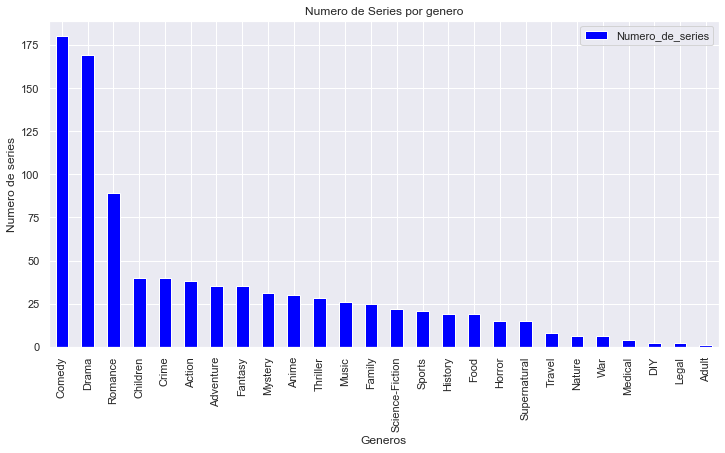

In [81]:
#generamos un diccionario para almacenar los datos por el genero de la serie
genresDict = dict()

for genre in df_series["genres_reform"]:
    for elem in genre:
        if elem not in genresDict:
            genresDict[elem] = 1
        else:
            genresDict[elem] += 1


sns.set(rc={'figure.figsize':(12,6)})
genres_df = pd.DataFrame.from_dict(genresDict, orient='index')
genres_df.columns = ["Numero_de_series"]
genres_df = genres_df.sort_values(by="Numero_de_series", ascending=False)
genres_df.plot.bar(color='blue')
plt.title("Numero de Series por genero")
plt.ylabel("Numero de series")
plt.xlabel("Generos")

## 7.3 Análisis por country

Al analizar los datos no hay una columna que indique el pais, pero si encontre unas columnas de country para network, web channel y dvd. Para hacer el proceso uní la información de estas columnas y cree un dataframe que me trae los id show, el nombre del show y el país para generar la gráfica, vale la pena aclarar que solo se encontró pais para es 319 Shows

In [74]:
#Sacamos la información de los dataframes para luego concatenarlos
Country_shows1=df_diciembre[['show_id',
                            'show_name',
                            'show_rating_average',
                            'show_webChannel_country_name'
                            ]].copy()

Country_shows1.columns=['show_id',
                'show_name',
                'rating_average',
                'country_name']

Country_shows2=df_diciembre[['show_id',
                            'show_name',
                            'show_rating_average',
                            'show_network_country_name'
                            ]].copy()

Country_shows2.columns=['show_id',
                'show_name',
                'rating_average',
                'country_name']

Country_shows3=df_diciembre[['show_id',
                            'show_name',
                            'show_rating_average',
                            'show_dvdCountry_name'
                            ]].copy()

Country_shows3.columns=['show_id',
                'show_name',
                'rating_average',
                'country_name']

Country_shows=pd.concat([Country_shows1,Country_shows2,Country_shows3])

In [75]:
#Quitamos duplicados
Country_shows.drop_duplicates(inplace=True)
Country_shows=Country_shows.dropna(subset=['country_name'])

In [76]:
Country_shows.reset_index(inplace=True,drop=True)
Country_shows.head(2)

,show_id,show_name,rating_average,country_name
0,41648,Sim for You,NaN,"Korea, Republic of"
1,52198,Котики,NaN,Russian Federation


Text(0.5, 1.0, 'Cantidad de Shows por País')

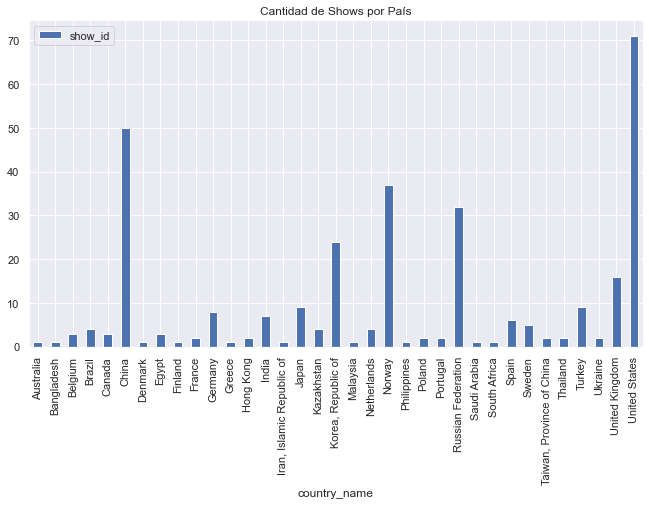

In [77]:
#Ahora generamos la gráfica de ejemplo
sns.set(rc={'figure.figsize':(11,6)})
Country_shows.groupby('country_name')['show_id'].count().plot(kind='bar',legend='Reverse')

plt.title('Cantidad de Shows por País')

In [78]:
Country_shows['show_id'].count()

319

## 7.4 Rating promedio por país y género

Este caso vale la pena validarlo ya que la cantidad de shows que tiene rating y country son solo 27, lo cual no es un valor significativo frente a la muestra total. Por tal motivo validaria con negocio como conseguir una mejor fuente para estos datos o realizar cruces con otras bases para encontrar la manera de hallar los paises de los shows con rating average

In [65]:
Country_shows['rating_average'].nunique()

27